In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from torch import nn
import random

In [2]:
import sys
sys.path.append("..")
# from steganogan.decoders import DenseDecoderNLayers
from steganogan.decoders import BasicDecoder, DenseDecoder, DenseDecoderNLayers
from steganogan import SteganoGAN

In [3]:
import torch
import torchvision

In [234]:
from tqdm import tqdm, trange

In [4]:
def shuffle_params(m):
    if type(m)==nn.Conv2d or type(m)==nn.BatchNorm2d:
        param = m.weight
        m.weight.data = nn.Parameter(torch.tensor(np.random.normal(0, 1, param.shape)).float())
        
        param = m.bias
        m.bias.data = nn.Parameter(torch.zeros(len(param.view(-1))).float().reshape(param.shape))
#         

In [188]:
class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.layers = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.data_depth)
        )

        return [self.layers]

    def __init__(self, data_depth, hidden_size):
        super().__init__()
        self.version = '1'
        self.data_depth = data_depth
        self.hidden_size = hidden_size

        self._models = self._build_models()

    def upgrade_legacy(self):
        """Transform legacy pretrained models to make them usable with new code versions."""
        # Transform to version 1
        if not hasattr(self, 'version'):
            self._models = [self.layers]

            self.version = '1'

    def forward(self, x):
        x = self._models[0](x)

        if len(self._models) > 1:
            x_list = [x]
            for layer in self._models[1:]:
                x = layer(torch.cat(x_list, dim=1))
                x_list.append(x)

        return x

In [281]:
# models
model_name = "steg_decode_new"
if model_name == "steg_decode":
#     steganogan = SteganoGAN.load(architecture='dense', path=None, cuda=True, verbose=True)
    steganogan = SteganoGAN.load(path="demo_1.1.steg", cuda=True, verbose=True)
    model = steganogan.decoder
    model.apply(shuffle_params)
elif model_name == "steg_decode_new":
    model = BasicDecoder(1, hidden_size=32)
    model.apply(shuffle_params)
    model.to('cuda')
else:
    print("unknown model")

model.to('cuda')
model.eval()

BasicDecoder(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [200]:
print(model.layers[2])
print(model.layers[2].weight)
print(model.layers[2].bias)

BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Parameter containing:
tensor([ 1.4835,  0.9145,  0.7252, -0.9820,  0.0477, -0.2512, -0.3702,  1.6210,
        -0.0628,  1.4258,  0.7858, -0.5171,  1.2037, -0.1013,  1.6816, -0.5115,
        -0.8941, -0.2934,  0.2254, -0.3147, -0.2991, -0.9382, -1.1833, -0.4964,
        -2.2796,  0.1107,  0.6674, -0.2300,  0.4985, -0.0958, -1.0812,  0.8908],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)


In [24]:
model

BasicDecoder(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [28]:
# load image
image = "/home/vk352/FaceDetection/datasets/sample/obama2.jpg"
image = imread(image, pilmode='RGB') 
image.shape

(612, 450, 3)

In [273]:
# extract a bit vector
image = "/home/vk352/FaceDetection/datasets/sample/obama2.jpg"
image = "/home/vk352/FaceDetection/datasets/data512x512/00001.jpg"
image = imread(image, pilmode='RGB') / 255.0
image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
image = image.to('cuda')
out = model(image)
# image = self.decoder(image).view(-1) > 0

In [275]:
target = torch.bernoulli(torch.empty(out.shape).uniform_(0, 1)).to(out.device)
target.shape

torch.Size([1, 1, 512, 512])

In [282]:
norm_acc = {}
norm_img = {}

steps = 1000
alpha=2/255
adv_image = image.clone().detach()

hinge = 0.3

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    accuracy = []

    for i in trange(steps):
        adv_image.requires_grad = True
        outputs = model(adv_image)

        loss = criterion(outputs, target)

        grad = torch.autograd.grad(loss, adv_image, retain_graph=False, create_graph=False)[0]

        adv_image = adv_image.detach() - alpha*grad.sign()
        delta = torch.clamp(adv_image - image, min=-eps, max=eps)
        adv_image = torch.clamp(image + delta, min=0, max=1).detach()
        accuracy.append(len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel())

    norm_acc[eps] = accuracy
    norm_img[eps] = adv_image.cpu().squeeze().permute(2,1,0)


 91%|█████████ | 906/1000 [00:16<00:01, 55.65it/s]


100%|██████████| 1000/1000 [00:17<00:00, 55.60it/s][A


In [241]:
print(hingelogacc.keys())

dict_keys([0.1])


In [239]:
hingelogacc = {}

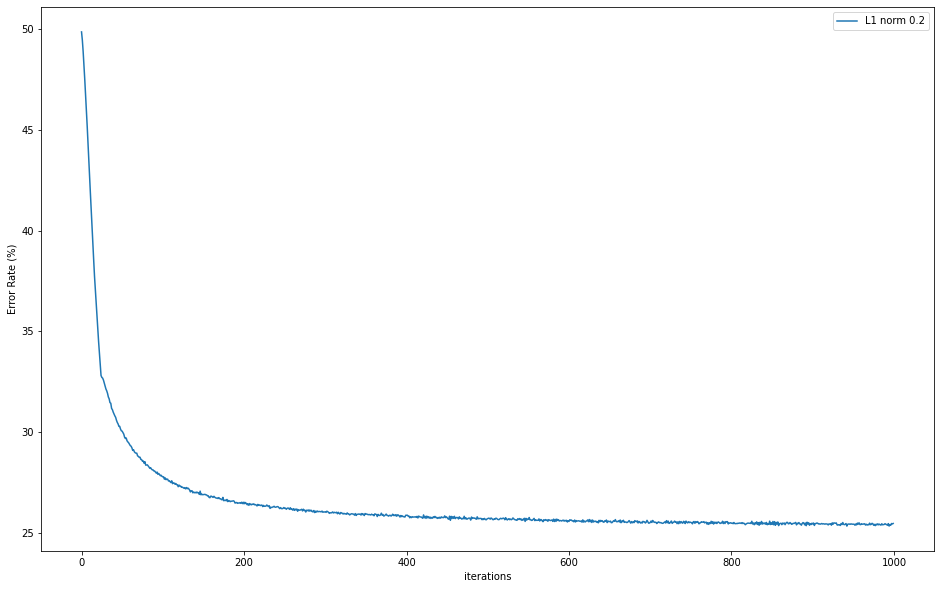

In [284]:
plt.figure(figsize=(16, 10))
# plt.plot(range(1000), np.array(bceacc) * 100, label="BCE Loss")
# plt.plot(range(1000), np.array(logacc) * 100, label="Log Loss")
# plt.plot(range(1000), np.array(hingeacc) * 100, label="Hinge Loss")
for norm, acc in norm_acc.items():
    plt.plot(range(1000), np.array(acc) * 100, label=f"L1 norm {norm}")
plt.legend()
plt.ylabel("Error Rate (%)")
plt.xlabel("iterations")
# plt.ylim(0, 2)
plt.show()

In [169]:
output = (model(adv_image)>0)
# output = (out>0)

In [170]:
print("Number of Incorrect bits:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))))
print("Total bits:")
print(target.numel())
print("Error rate:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))) / target.numel())

Number of Incorrect bits:
44
Total bits:
275400
Error rate:
0.0001597676107480029


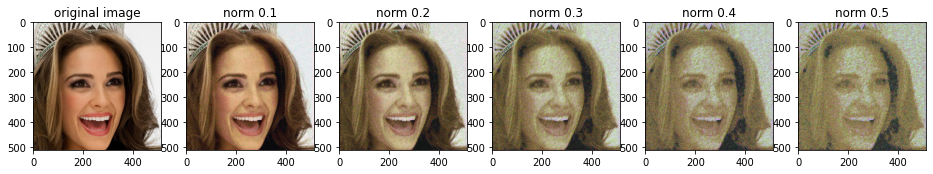

In [280]:
fig, axs = plt.subplots(1, len(norm_img)+1, figsize=(16, 6))

axs[0].imshow(image.cpu().squeeze().permute(2,1,0))
axs[0].set_title("original image")
for i, eps in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    axs[i+1].imshow(norm_img[eps])
    axs[i+1].set_title(f"norm {eps}")

In [245]:
image.shape

torch.Size([1, 3, 450, 612])

In [248]:
hingeacc

[0.42137981118373274,
 0.39088235294117646,
 0.3482135076252723,
 0.3200036310820625,
 0.2906318082788671,
 0.26743282498184456,
 0.2458859840232389,
 0.22705882352941176,
 0.209880174291939,
 0.1944480755265069,
 0.1809840232389252,
 0.16911038489469862,
 0.1569281045751634,
 0.1482244008714597,
 0.13775599128540306,
 0.13014161220043574,
 0.12268336964415395,
 0.11444081336238199,
 0.10978939724037763,
 0.10255628177196804,
 0.09684458968772694,
 0.09223674655047204,
 0.08767247639796659,
 0.08404502541757444,
 0.08022149600580973,
 0.0752723311546841,
 0.07209513435003631,
 0.06848220769789397,
 0.0663035584604212,
 0.06316267247639797,
 0.06073710965867828,
 0.05872185911401598,
 0.0561837327523602,
 0.05403776325344953,
 0.05233478576615831,
 0.04987654320987654,
 0.04855119825708061,
 0.04729847494553377,
 0.04469862018881627,
 0.0431118373275236,
 0.04255265068990559,
 0.040185185185185185,
 0.03930646332607117,
 0.03812999273783588,
 0.03695352214960058,
 0.03552287581699346,
 

In [250]:
x = {"hingelogacc": hingelogacc, "bceacc": bceacc, "hingeacc": hingeacc, "logacc": logacc}
import pickle
with open("accs.pkl", "wb") as f:
    pickle.dump(x, f)

In [ ]:
with open("accs.pkl", "rb") as f:
    accs = pickle.load(f)